In [ ]:
!pip install gluonts
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to 

In [ ]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df = df[df.unique_id == "BE"]
df

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10
...,...,...,...
1675,BE,2016-12-30 19:00:00,57.42
1676,BE,2016-12-30 20:00:00,57.56
1677,BE,2016-12-30 21:00:00,52.18
1678,BE,2016-12-30 22:00:00,54.38


In [ ]:
# Initialize variables
historical_days = 7
window_size = 24 * historical_days  # 24 hours a day
prediction_length = 24  # Predict 24 hours

columns_to_extract = [str(i/10) for i in range(1,10)]

pred_dict = {}
actual_dict = {}
best_model_name = []

# Iterate through the time series data by rolling window
for start_idx in range(len(df) - window_size):
    # Slice the data for the current rolling window
    rolling_window = df.iloc[start_idx : start_idx + window_size]

    # Convert rolling_window to a TimeSeriesDataFrame
    train_data = TimeSeriesDataFrame.from_data_frame(
        rolling_window,
        id_column='unique_id',  # Specify the item_id column
        timestamp_column='ds'  # Specify the timestamp column
    )

    # Fit the TimeSeriesPredictor on the rolling window
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        path="multiple-timeseries/electric-hourly-1week_rollingwindow",
        freq="H",
        target="y",
        eval_metric="MSE",
    )
    predictor.fit(train_data, presets="fast_training", random_seed=42)

    # Predict the next hour
    prediction = predictor.predict(train_data, random_seed=42)

    # Add the predictions to the list
    pred_dict[df.iloc[start_idx + window_size].ds] = prediction[columns_to_extract].to_numpy().transpose()
    actual_dict[df.iloc[start_idx + window_size].ds] = df.iloc[start_idx + window_size].y

    best_model_name.append(predictor.info()["best_model"])

Streaming output truncated to the last 5000 lines.
	-193.5140     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.22    s     = Validation (prediction) runtime
Training timeseries model Theta. 
	-103.6659     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DirectTabular': 0.1, 'RecursiveTabular': 0.58, 'SeasonalNaive': 0.12, 'Theta': 0.19}
	-67.5213      = Validation score (-MSE)
	1.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'WeightedEnsemble']
Total runtime: 4.19 s
Best model: WeightedEnsemble
Best model score: -67.5213
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/usr/local/lib/python3.11/dist-packages/autogluon/timeseries/predictor.py:197: Futu

In [ ]:
# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for time, predictions in pred_dict.items():
    row = {'time' : time}  # Start with the time as the first element
    for i in range(predictions.shape[1]):
        row[f'step{i+1}'] = predictions[:, i]  # Append each array of length 9 as separate column values
    data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

actual_df = pd.DataFrame(list(actual_dict.items()), columns=['time', 'actual'])

# Convert 'time' column to datetime objects if they are not already
actual_df['time'] = pd.to_datetime(actual_df['time'])
pred_df['time'] = pd.to_datetime(pred_df['time'])

# Merge the DataFrames on the 'time' column
merged_df = pd.merge(actual_df, pred_df, on='time', how='inner')
merged_df['best_model'] = best_model_name
merged_df

NameError: name 'pred_dict' is not defined

In [ ]:
#merged_df.to_pickle('/content/drive/My Drive/autogluon_elec_BE_C1w_P1h_predinterval.pkl')

In [ ]:
import pandas as pd

#Predictions from Auto-gluon
pred_autogluon = pd.read_pickle('/content/drive/My Drive/autogluon_elec_BE_C1w_P1h_predinterval.pkl')
pred_autogluon.drop(columns = ['actual'], inplace = True)

#predictions from Lag-LLama model
pred_lagllama = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C1w_P24h_pred_interval.pkl')

In [ ]:
# Merge the two dataframes
merged_df = pd.merge(pred_lagllama, pred_autogluon, on='time', suffixes=('_lagllama', '_autogluon'))

In [ ]:
merged_df_step1 = merged_df[['time', 'actual', 'step1_lagllama', 'step1_autogluon']]

In [ ]:
def calculate_sigma(percentiles):
    z_10, z_90 = -1.28155, 1.28155  # Standard normal quantiles
    sigma_factor = z_90 - z_10  # 2.5631
    return (percentiles[8] - percentiles[0]) / sigma_factor

def calculate_sigma_from_array(values):
    return np.std(values, ddof=0)  # Population standard deviation

# Apply function using lambda
merged_df_step1.loc[:,'autogluon_sigma'] = merged_df_step1['step1_autogluon'].apply(lambda x: calculate_sigma(x))
merged_df_step1.loc[:,'lagllama_sigma'] = merged_df_step1['step1_lagllama'].apply(calculate_sigma_from_array)
merged_df_step1.loc[:,'autogluon_mean'] = merged_df_step1['step1_autogluon'].apply(lambda x: x[4])
merged_df_step1.loc[:,'lagllama_mean'] = merged_df_step1['step1_lagllama'].apply(lambda x: np.mean(x))

merged_df_step1

<ipython-input-7-7e4073a4acaf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_step1.loc[:,'autogluon_sigma'] = merged_df_step1['step1_autogluon'].apply(lambda x: calculate_sigma(x))
<ipython-input-7-7e4073a4acaf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_step1.loc[:,'lagllama_sigma'] = merged_df_step1['step1_lagllama'].apply(calculate_sigma_from_array)
<ipython-input-7-7e4073a4acaf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,time,actual,step1_lagllama,step1_autogluon,autogluon_sigma,lagllama_sigma,autogluon_mean,lagllama_mean
0,2016-10-29 00:00:00,53.029999,"[39.29847, 46.85613, 41.73501, 65.316124, 31.1...","[-11.123067333634415, 10.025144963844992, 25.2...",48.071789,12.354788,50.483334,51.478462
1,2016-10-29 01:00:00,47.680000,"[43.50239, 34.276146, 48.267384, 36.765198, 29...","[-5.013670543720611, 11.496147231461553, 23.40...",37.528301,13.351158,43.080724,43.597557
2,2016-10-29 02:00:00,46.000000,"[40.094704, 25.225666, 48.30184, 41.265545, 32...","[-16.293676716302592, 3.6468491732391586, 18.0...",45.326609,14.935410,41.794639,40.921761
3,2016-10-29 03:00:00,42.799999,"[22.819115, 52.48851, 29.54736, 41.47263, 12.2...","[-15.5933130744565, 3.8327275604025557, 17.840...",44.157138,12.327899,40.996267,36.050968
4,2016-10-29 04:00:00,39.430000,"[51.675724, 46.054085, 27.322285, 39.187393, 4...","[-11.003781263105807, 7.517120630631407, 20.87...",42.123086,15.697069,42.971340,34.567589
...,...,...,...,...,...,...,...,...
1507,2016-12-30 19:00:00,57.419998,"[68.23987, 0.0, 74.03635, 67.45534, 79.6763, 7...","[47.08415966042378, 50.7364931179159, 53.37661...",8.568620,19.500229,57.977374,74.137909
1508,2016-12-30 20:00:00,57.560001,"[65.06552, 55.568752, 60.818283, 53.051685, 64...","[41.69945548240412, 44.93724740985548, 47.2785...",7.630516,7.464229,51.389063,58.179886
1509,2016-12-30 21:00:00,52.180000,"[48.274376, 50.48092, 45.180943, 54.457733, 54...","[46.106409302679104, 49.33732705694561, 51.667...",7.344167,7.466135,55.518326,49.047489
1510,2016-12-30 22:00:00,54.380001,"[52.927383, 50.26232, 44.08007, 50.18791, 49.9...","[37.39360912150864, 41.228595464884805, 43.993...",8.717269,4.726315,48.565225,47.557701


In [ ]:
merged_df = merged_df_step1[['time', 'actual', 'autogluon_sigma', 'autogluon_mean', 'lagllama_sigma', 'lagllama_mean']]
merged_df.rename(columns = {'autogluon_mean':'step1_autogluon','lagllama_mean':'step1_lagllama'}, inplace = True)

<ipython-input-8-5cc955068ea2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.rename(columns = {'autogluon_mean':'step1_autogluon','lagllama_mean':'step1_lagllama'}, inplace = True)


In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize list to store the differences
mse_lagllama = []
mse_autogluon = []
mse_avg = []
mse_04l_06a = []
mse_025l_075a = []
mse_075l_025a = []
mse_max = []
mse_min = []

# Loop through the prediction steps (1 to 24)
for x in range(1, 2):
    # Calculate the differences
    temp = merged_df.copy()
    temp['actual_lag'] = merged_df['actual'].shift(-x+1)
    temp['avg'] = (merged_df[f'step{x}_lagllama'] + merged_df[f'step{x}_autogluon']) / 2
    temp['0.4l_0.6a'] = merged_df[f'step{x}_lagllama'] * 0.4 + merged_df[f'step{x}_autogluon'] * 0.6
    temp['0.25l_0.75a'] = merged_df[f'step{x}_lagllama'] * 0.25 + merged_df[f'step{x}_autogluon'] * 0.75
    temp['0.75l_0.25a'] = merged_df[f'step{x}_lagllama'] * 0.75 + merged_df[f'step{x}_autogluon'] * 0.25

    if x == 1:
      temp2 = temp
    else:
      temp2 = temp.iloc[:(-x+1)]

    mse_lagllama.append(mean_squared_error(temp2[f'step{x}_lagllama'], temp2['actual_lag']))
    mse_autogluon.append(mean_squared_error(temp2[f'step{x}_autogluon'], temp2['actual_lag']))
    mse_avg.append(mean_squared_error(temp2['avg'], temp2['actual_lag']))
    mse_04l_06a.append(mean_squared_error(temp2['0.4l_0.6a'], temp2['actual_lag']))
    mse_025l_075a.append(mean_squared_error(temp2['0.25l_0.75a'], temp2['actual_lag']))
    mse_075l_025a.append(mean_squared_error(temp2['0.75l_0.25a'], temp2['actual_lag']))

print(f"MSE for LagLLama: {mse_lagllama}")
print(f"MSE for AutoGluon: {mse_autogluon}")
print(f"MSE for Average Difference: {mse_avg}")
print(f"MSE for 0.4l_0.6a: {mse_04l_06a}")
print(f"MSE for 0.25l_0.75a: {mse_025l_075a}")


MSE for LagLLama: [1297.6904296875]
MSE for AutoGluon: [1077.7858072453764]
MSE for Average Difference: [995.7693344950516]
MSE for 0.4l_0.6a: [981.4576147717429]
MSE for 0.25l_0.75a: [988.7853572782366]


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

mse_cv_min_step = []
mse_cv_max_step = []
mse_cv_avg_step = []
mse_train_step = []
mse_test_step = []
mse_overall_step = []
coeff_lagllama_step = []
coeff_autogluon_step = []

for x in range(1, 2):
  # Prepare the data for the regression model
  if x == 1:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']]
    y = merged_df['actual']
  else:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].iloc[:(-x+1)]
    y = merged_df['actual'].shift(-x+1).iloc[:(-x+1)]

  # Split the data into training and testing sets
  X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Important: shuffle=False to maintain time order

  # Define the time series cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Initialize lists to store results
  mse_scores = []

  # Perform cross-validation
  for train_index, val_index in tscv.split(X_cv):
      X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
      y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

      # Initialize and train the linear regression model
      model = LinearRegression(fit_intercept = False)
      model.fit(X_train, y_train)

      # Make predictions on the test set
      y_val_pred = model.predict(X_val)

      # Calculate MSE and store results
      mse = mean_squared_error(y_val, y_val_pred)
      mse_scores.append(mse)

  # Print the average MSE across all folds
  avg_mse = np.mean(mse_scores)
  min_mse = np.min(mse_scores)
  max_mse = np.max(mse_scores)
  mse_cv_avg_step.append(avg_mse)
  mse_cv_min_step.append(min_mse)
  mse_cv_max_step.append(max_mse)
  #print(f"Average MSE across folds: {avg_mse}")

  #train model on overall train data (cv)
  model = LinearRegression(fit_intercept = False)
  model.fit(X_cv, y_cv)

  coefficients = model.coef_
  coeff_lagllama_step.append(coefficients[0])
  coeff_autogluon_step.append(coefficients[1])

  #mse on overall data
  y_cv_pred = model.predict(X_cv)
  mse_train = mean_squared_error(y_cv, y_cv_pred)
  #print(f"MSE on overall train data: {mse_train}")
  mse_train_step.append(mse_train)

  #test the model on test data
  y_test_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_test_pred)
  mse_test_step.append(mse_test)
  #print(f"MSE on test data: {mse_test}")

  #mse on complete data
  y_pred = model.predict(X)
  mse_overall = mean_squared_error(y, y_pred)
  mse_overall_step.append(mse_overall)
  #print(f"MSE on complete data: {mse_overall}")

In [ ]:
#print all the lists difened ending with _step

# Print all list defined ending with _step
#print(f"mse_cv_avg_step: {mse_cv_avg_step}")
#print(f"mse_train_step: {mse_train_step}")
#print(f"mse_test_step: {mse_test_step}")
print(f"mse_overall_step: {mse_overall_step}") #overall- train and test data.
print(f"coeff_lagllama_step: {coeff_lagllama_step}")
print(f"coeff_autogluon_step: {coeff_autogluon_step}")


mse_overall_step: [962.1993215952132]
coeff_lagllama_step: [0.3247853164532576]
coeff_autogluon_step: [0.6056164331913649]


In [ ]:
import numpy as np
import pandas as pd

def ensemble_statistics_df(df, mu1_col, sigma1_col, mu2_col, sigma2_col, w1, w2, rho=0):
    """
    Compute ensemble mean, standard deviation, and confidence interval for each row in a DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing model statistics.
    - mu1_col, sigma1_col: Column names for Model 1 mean and standard deviation.
    - mu2_col, sigma2_col: Column names for Model 2 mean and standard deviation.
    - w1, w2: Weights for each model (w1 + w2 = 1).
    - rho: Correlation between the models (default is 0 for independence).

    Returns:
    - DataFrame with additional columns for ensemble mean, standard deviation, and confidence interval.
    """
    # Compute ensemble mean
    df['ensemble_mean'] = w1 * df[mu1_col] + w2 * df[mu2_col]

    # Compute ensemble variance
    df['ensemble_variance'] = (
        (w1 ** 2) * (df[sigma1_col] ** 2) +
        (w2 ** 2) * (df[sigma2_col] ** 2) +
        (2 * w1 * w2 * rho * df[sigma1_col] * df[sigma2_col])
    )

    # Compute ensemble standard deviation
    df['ensemble_std'] = np.sqrt(df['ensemble_variance'])

    # Compute 95% confidence interval
    df['ci_lower'] = df['ensemble_mean'] - 1.96 * df['ensemble_std']
    df['ci_upper'] = df['ensemble_mean'] + 1.96 * df['ensemble_std']

    return df

# Apply ensemble function
w1, w2 = coeff_lagllama_step[0], coeff_autogluon_step[0]  # Model weights
rho = 0  # Correlation between models
merged_df_1 = ensemble_statistics_df(merged_df, 'step1_lagllama', 'lagllama_sigma', 'step1_autogluon', 'autogluon_sigma', w1, w2, rho)

w1, w2 = 0.5, 0.5
merged_df_2 = ensemble_statistics_df(merged_df, 'step1_lagllama', 'lagllama_sigma', 'step1_autogluon', 'autogluon_sigma', w1, w2, rho)


<ipython-input-11-af3aa5138bde>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ensemble_mean'] = w1 * df[mu1_col] + w2 * df[mu2_col]


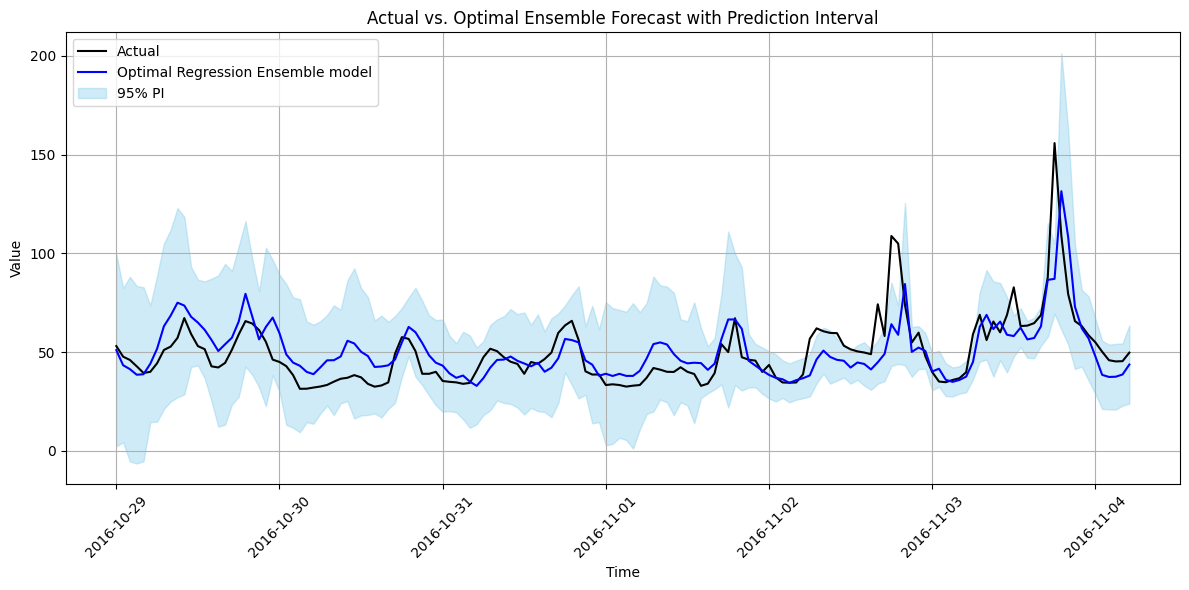

In [ ]:
import matplotlib.pyplot as plt

# Assuming merged_df_1 is your DataFrame with ensemble statistics

# Select the first 200 observations
merged_df_plot = merged_df_1.head(150)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged_df_plot['time'], merged_df_plot['actual'], label='Actual', color='black')

# Plot ensemble mean
plt.plot(merged_df_plot['time'], merged_df_plot['ensemble_mean'], label='Optimal Regression Ensemble model', color='blue')

# Plot confidence intervals
plt.fill_between(merged_df_plot['time'], merged_df_plot['ci_lower'], merged_df_plot['ci_upper'], color='skyblue', alpha=0.4, label='95% PI')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Optimal Ensemble Forecast with Prediction Interval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


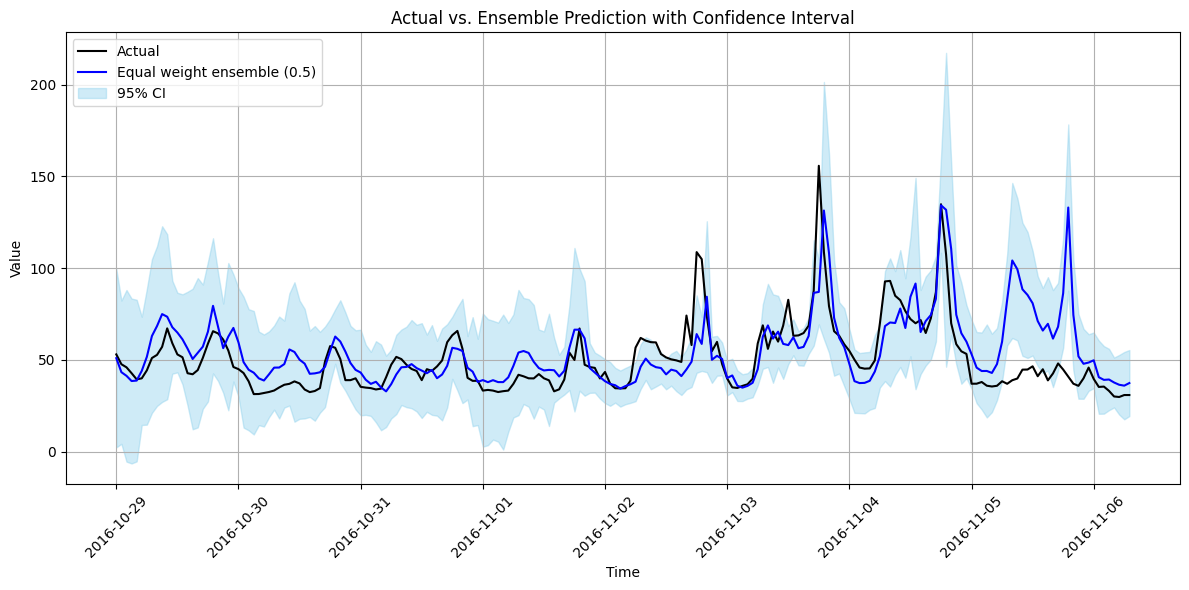

In [ ]:
import matplotlib.pyplot as plt

# Assuming merged_df_1 is your DataFrame with ensemble statistics

# Select the first 200 observations
merged_df_plot = merged_df_2.head(200)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged_df_plot['time'], merged_df_plot['actual'], label='Actual', color='black')

# Plot ensemble mean
plt.plot(merged_df_plot['time'], merged_df_plot['ensemble_mean'], label='Equal weight ensemble (0.5)', color='blue')

# Plot confidence intervals
plt.fill_between(merged_df_plot['time'], merged_df_plot['ci_lower'], merged_df_plot['ci_upper'], color='skyblue', alpha=0.4, label='95% CI')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Ensemble Prediction with Confidence Interval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()